# Linear Regression

Today we will start working on our first Machine Learning model: Linear Regression.

# TODO:
- change variables for non-challenge predictor
- extend evaluation sections
- add 3D visualization for multivariate regression
- make sure we're just using one regression function consistently
- maybe implement it by hand first? To show how least squares works? May be too much

# Table of contents
[1. Linear Regression](#3.-Linear-Regression)
- evaluation

[2. Multivariate-Regression](#4.-Multivariate-Regression)
- evaluation


# Linear Regression

Linear regression is a linear approach to modelling the relationship between a continuous variable (called the outcome or the dependent variable) and one explanatory variable (called predictor or independent variable). 

In linear regression, we plot the data on a scatter plot and then compute the best-fit line through the data points. The term "best-fit" refers to the fact that the resulting line minimizes the squared distance between the data points and the line. 

The best-fit line is described by the equation:

$$Y = c_0 + c_1 X + \epsilon$$

where $c_0$ is the regression coefficient associated with the value of $Y$ when $X=0$, $c_1$ is the regression coefficient that tells us by how much $Y$ changes when $X$ is not zero, and $\epsilon$ is noise. For now, we will set $\epsilon$ to zero, meaning we will ignore the effects of noise. The resulting equation $Y = c_0 + c_1 X$ is just the equation for a line with $c_0$ as its y-intercept and $c_1$ is its slope. 

The best-fit line provides what is known as a linear model which allows us to make predictions about the value of $Y$ given the value of $X$.

In [16]:
# First, we import the libraries we will use in this notebook and load the Fragile Families data. 
# The first line sets maplotlib plots to show inside the notebook.
%matplotlib inline 
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import sys
import ff_functions as fff

In [19]:
# Read in data
background = "../../ai4all_data/background.csv"

data_frame = pd.read_csv(background, low_memory=False)
data_frame = data_frame.set_index('challengeID')

### Linear regression for income using mother's age at the time of birth ('cm1age') as predictor 
In this section we will build a linear regression model to predict the family's income in year 2 ('f2l1'). As a predictor, we will use the mother's age at the time of child's birth (feature 'cm1age').

In [24]:
age_income = fff.pick_ff_variables(data_frame, ["cm1age", "cf1age", "f2l1"], remove_nans=True, remove_negatives=True)

In [25]:
age_income.head()

,cm1age,cf1age,f2l1
challengeID,,,
4,22,24,31037.239985
6,18,20,37215.440460
9,21,24,23437.652319
11,22,31,19508.401102
13,22,22,26212.061488


Let's create a new feature that captures the parents' average age - after all, the income is provided per the entire family.

In [27]:
age_income["average_age"] = age_income.cm1age*0.5+ age_income.cf1age*0.5
age_income.head()

,cm1age,cf1age,f2l1,average_age
challengeID,,,,
4,22,24,31037.239985,23.0
6,18,20,37215.440460,19.0
9,21,24,23437.652319,22.5
11,22,31,19508.401102,26.5
13,22,22,26212.061488,22.0


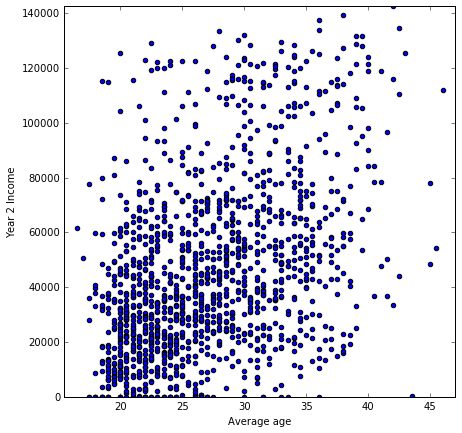

In [29]:
fff.scatterplot(age_income.average_age, age_income.f2l1, xlabel = "Average age", ylabel = "Year 2 Income")

In [31]:
# First, let's split our data into train and test sets
from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(edu_nonan.t5c13a, edu_nonan.gpa, test_size = 0.3, random_state = 100)

train, test = train_test_split(age_income, test_size = 0.3, random_state = 100)
train_X = train.average_age
train_y = train.f2l1

test_X = test.average_age
test_y = test.f2l1
print(train.shape)
print(test.shape)

(970, 4)
(416, 4)


**Let's do linear regression with `numpy.polyfit`** You can learn about this function at <https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polyfit.html>


slope : 2434.570709259978
intercept : -20213.274164540915


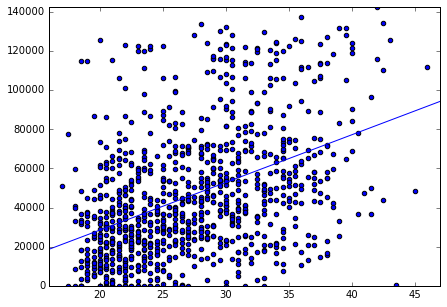

In [45]:
# the argument "1" tells polyfit we are doing an linear regression (linear is degree 1)
coef = np.polyfit(train_X,train_y,1)
slope = coef[0]
intercept = coef[1]
print('slope : {}'.format(slope))
print('intercept : {}'.format(intercept))

# we plot the regression line along with the data points
fff.scatterplot_with_line(train_X,train_y, slope, intercept)

2.1 Evaluation and Generalization

mean square error : 820686116.0494232
mean root of square error : 28647.619727464677


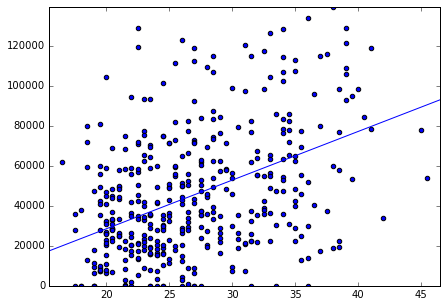

In [44]:
# calculate mean square error ON THE TEST DATA
test_mse = np.mean(((slope*test_X + intercept - test_y) ** 2))
print('mean square error : {}'.format(test_mse))
print('mean root of square error : {}'.format(np.sqrt(test_mse)))

fff.scatterplot_with_line(test_X,test_y, slope, intercept)

In [43]:
# calculate mean square error ON THE TRAIN DATA
train_mse = np.mean(((slope*train_X + intercept - train_y) ** 2))
print('mean square error : {}'.format(train_mse))
print('mean root of square error : {}'.format(np.sqrt(train_mse)))

mean square error : 847504887.8271335
mean root of square error : 29111.93720498747


## Problem 1.1
Run regression of family income in year 9 vs Father's age ('m5j1' vs 'cf1age')

(hint: Repeat the following steps:)

* read in the data frame with the desired variables, NaNs and below-zero values removed
* create a train and test split
* train an regression model on the train data
* test the regression model on the test data
* test the regression model on the train data (for sanity check)


## Problem 1.2
Do the same for income in year 9 vs Mother's age ('m5j1' vs 'cm1age').

Which variable was a better predictor?

# 2. Multivariate Linear Regression
2 predictors - plot in 3D

can add more but it's hard to visualize.

## Multiple Linear Regression

Multiple linear regression is a generalization of linear regression. In multiple linear regression we model the relationship between a continuous variable (called the outcome or the dependent variable) and multiple explanatory variables (called predictors or independent variables). 

As in linear regression, we plot the data on a scatter plot and then compute the best-fit line through the data points. However, we use a different equation for the best-fit line which takes into account the effects of multiple predictors $X_1,X_2,\dots,X_n$: 

The best-fit line is described by the equation:

$$Y = c_0 + c_1 X_1 + c_2 X_2 + c_3 X_3 + \dots + c_n X_n + \epsilon$$

where $c_0$ is the regression coefficient associated with the value of $Y$ when $X=0$, and $c_i$ where $i = 1,2,3,\dots,n$ is the regression coefficient that tells us by how much $Y$ changes when the predictor $X_i$ is not zero. As before, we will set $\epsilon$ to zero, meaning we will ignore the effects of noise.

The best-fit line provides what is known as a linear model which allows us to make predictions about the value of $Y$ given the values of $X_i$.

In this section we will build a multiple linear regression model to predict the child's GPA scores. As predictors, we will use language and literacy skills (feature t5c13a), science and social skills (feature t5c13b), and math skills (feature t5c13c).

In [19]:
#Remember our dataframe X and GPA
edu_nonan.head()

,t5c13a,t5c13b,t5c13c,gpa
challengeID,,,,
9,1,2,2,2.25
14,3,4,4,3.25
16,1,2,2,2.00
18,2,2,2,2.25
23,2,4,3,2.50


Let's reshuffle the data

In [20]:
# Split our data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(edu_nonan.iloc[:,:3], edu_nonan.gpa, test_size = 0.3, random_state = 100)

print(X_train.shape)
print(X_test.shape)

(513, 3)
(221, 3)


In this section, we'll again use `sklearn.linear_model.LinearRegression` to do multiple linear regression.

In [21]:
# fit the linear regression model and get the slope and intercept
reg = linear_model.LinearRegression()

reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We denote $X_1$, $X_2$, $X_3$ as three features `t5c13a`, `t5c13b`, `t5c13c`, respectively. Then the multiple regression model can be written as 

$Y = c_0 + c_1 X_1 + c_2 X_2 + c_3 X_3 + \epsilon$

The coefficients can be retrieved from the fitted model.


In [22]:
print('[c_1 c_2 c_3] = {}'.format(reg.coef_))
print('c_0 = {}'.format(reg.intercept_))

[c_1 c_2 c_3] = [ 0.07342398  0.07174348  0.07980745]
c_0 = 2.232323274548894


We can use this model to predict the GPA for students in the test set.

In [23]:
y_predict = reg.predict(X_test)

# calculate mean square error
mse_test = np.mean(((y_predict - y_test) ** 2))
print('mean square error of prediction : {}'.format(mse_test))

mean square error of prediction : 0.4480834881179986


In [24]:
slope = reg.coef_
intercept = reg.intercept_

In [29]:
reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)